In [117]:
import cv2

import pandas as pd
import numpy as np
import xml.etree.cElementTree as ET

from shapely.geometry import Point, Polygon
from geopandas import GeoDataFrame

import matplotlib.pylab as plt
%matplotlib inline

In [118]:
def xml_content_to_dataframe(xml_file: str) -> pd.DataFrame:

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text
        name = boxes.find("name").text

        ymin, xmin, ymax, xmax = None, None, None, None


        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [name, xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

        df = GeoDataFrame(list_with_all_boxes, columns=["name", "xmin", "ymin", "xmax", "ymax"])
        
    return df

def draw_boundingbox_from_daraframe(image, dataframe):

    img = image.copy()
 
    for row in dataframe.itertuples():

        label = row.name

        ymin = row.ymin
        xmin = row.xmin
        ymax = row.ymax
        xmax=row.xmax        
  
        img = cv2.rectangle(
            img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 0, 255), 5
        )

    return img 

class Rect:
    def __init__(self, x, y, w, h):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
    
    def bottom(self):
        return self.y + self.h
    
    def right(self):
        return self.x + self.w
    
    def area(self):
        return self.w * self.h
    
    def center(self):
        return self.w/2, self.h/2
    
    def union(self, b):
        posX = min(self.x, b.x)
        posY = min(self.y, b.y)
        
        return Rect(posX, posY, max(self.right(), b.right()) - posX, max(self.bottom(), b.bottom()) - posY)
    
    def intersection(self, b):
        posX = max(self.x, b.x)
        posY = max(self.y, b.y)
        
        candidate = Rect(posX, posY, min(self.right(), b.right()) - posX, min(self.bottom(), b.bottom()) - posY)
        if candidate.w > 0 and candidate.h > 0:
            return candidate
        return Rect(0, 0, 0, 0)
    
    def ratio(self, b):
        return self.intersection(b).area() / self.union(b).area()

In [119]:
df_input = xml_content_to_dataframe("input.xml")
df_golden = xml_content_to_dataframe("golden.xml")

In [120]:
df_input = xml_content_to_dataframe("input.xml")
df_golden = xml_content_to_dataframe("golden.xml")

df_input['geometry'] = df_input.apply(lambda x: Polygon([(x["xmin"], x["ymin"]), (x["xmin"], x["xmax"] - x["xmin"]), (x["xmax"], x["ymax"]), (x["xmin"], x["ymax"] -x["ymin"])]), axis=1)
# df_input['geometry'] = df_input.apply(lambda x: Point(Rect(x["xmin"], x["ymin"], x["xmax"] - x["xmin"], x["ymax"] -x["ymin"]).center()), axis=1)
df_golden['geometry'] = df_golden.apply(lambda x: Polygon([(x["xmin"], x["ymin"]), (x["xmin"], x["xmax"] - x["xmin"]), (x["xmax"], x["ymax"]), (x["xmin"], x["ymax"] -x["ymin"])]), axis=1)

In [122]:
df_input

,name,xmin,ymin,xmax,ymax,geometry
0,small fish,342,16,478,101,"POLYGON ((342.000 16.000, 342.000 136.000, 478..."
1,big fish,221,490,459,646,"POLYGON ((221.000 490.000, 221.000 238.000, 45..."
2,small fish,579,564,723,641,"POLYGON ((579.000 564.000, 579.000 144.000, 72..."
3,big fish,1342,161,1558,337,"POLYGON ((1342.000 161.000, 1342.000 216.000, ..."
4,big fish,557,102,1045,492,"POLYGON ((557.000 102.000, 557.000 488.000, 10..."
5,small fish,1049,132,1087,176,"POLYGON ((1049.000 132.000, 1049.000 38.000, 1..."
6,small fish,389,652,484,694,"POLYGON ((389.000 652.000, 389.000 95.000, 484..."
7,small fish,914,514,964,556,"POLYGON ((914.000 514.000, 914.000 50.000, 964..."
8,small fish,639,640,688,676,"POLYGON ((639.000 640.000, 639.000 49.000, 688..."


In [123]:
df_golden

,name,xmin,ymin,xmax,ymax,geometry
0,big fish,251,504,485,654,"POLYGON ((251.000 504.000, 251.000 234.000, 48..."
1,small fish,583,572,748,660,"POLYGON ((583.000 572.000, 583.000 165.000, 74..."
2,big fish,1080,484,1236,597,"POLYGON ((1080.000 484.000, 1080.000 156.000, ..."
3,big fish,574,122,1076,505,"POLYGON ((574.000 122.000, 574.000 502.000, 10..."
4,big fish,1351,187,1583,369,"POLYGON ((1351.000 187.000, 1351.000 232.000, ..."
5,small fish,369,31,506,115,"POLYGON ((369.000 31.000, 369.000 137.000, 506..."
6,small fish,1081,148,1111,190,"POLYGON ((1081.000 148.000, 1081.000 30.000, 1..."
7,small fish,684,505,732,535,"POLYGON ((684.000 505.000, 684.000 48.000, 732..."
8,small fish,939,521,992,570,"POLYGON ((939.000 521.000, 939.000 53.000, 992..."
9,small fish,417,661,497,705,"POLYGON ((417.000 661.000, 417.000 80.000, 497..."


In [124]:
df_golden.sjoin(df_input, how="left")


,name_left,xmin_left,ymin_left,xmax_left,ymax_left,geometry,index_right,name_right,xmin_right,ymin_right,xmax_right,ymax_right
0,big fish,251,504,485,654,"POLYGON ((251.000 504.000, 251.000 234.000, 48...",6.0,small fish,389.0,652.0,484.0,694.0
0,big fish,251,504,485,654,"POLYGON ((251.000 504.000, 251.000 234.000, 48...",1.0,big fish,221.0,490.0,459.0,646.0
1,small fish,583,572,748,660,"POLYGON ((583.000 572.000, 583.000 165.000, 74...",4.0,big fish,557.0,102.0,1045.0,492.0
1,small fish,583,572,748,660,"POLYGON ((583.000 572.000, 583.000 165.000, 74...",8.0,small fish,639.0,640.0,688.0,676.0
1,small fish,583,572,748,660,"POLYGON ((583.000 572.000, 583.000 165.000, 74...",2.0,small fish,579.0,564.0,723.0,641.0
2,big fish,1080,484,1236,597,"POLYGON ((1080.000 484.000, 1080.000 156.000, ...",5.0,small fish,1049.0,132.0,1087.0,176.0
3,big fish,574,122,1076,505,"POLYGON ((574.000 122.000, 574.000 502.000, 10...",4.0,big fish,557.0,102.0,1045.0,492.0
3,big fish,574,122,1076,505,"POLYGON ((574.000 122.000, 574.000 502.000, 10...",7.0,small fish,914.0,514.0,964.0,556.0
3,big fish,574,122,1076,505,"POLYGON ((574.000 122.000, 574.000 502.000, 10...",8.0,small fish,639.0,640.0,688.0,676.0
3,big fish,574,122,1076,505,"POLYGON ((574.000 122.000, 574.000 502.000, 10...",2.0,small fish,579.0,564.0,723.0,641.0


In [125]:
missing_object = df_golden.sjoin(df_input, how="left", lsuffix = 'g', rsuffix= 'i')
missing_object = missing_object[missing_object['index_i'].isnull()].dropna(axis=1, how='all')
missing_object.columns = df_input.columns.to_list()

missing_object

,name,xmin,ymin,xmax,ymax,geometry
6,small fish,1081,148,1111,190,"POLYGON ((1081.000 148.000, 1081.000 30.000, 1..."


In [129]:
input_image = cv2.imread(r"golden.jpg")
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

In [130]:
missing_object_on_input_image = draw_boundingbox_from_daraframe(input_image, missing_object)

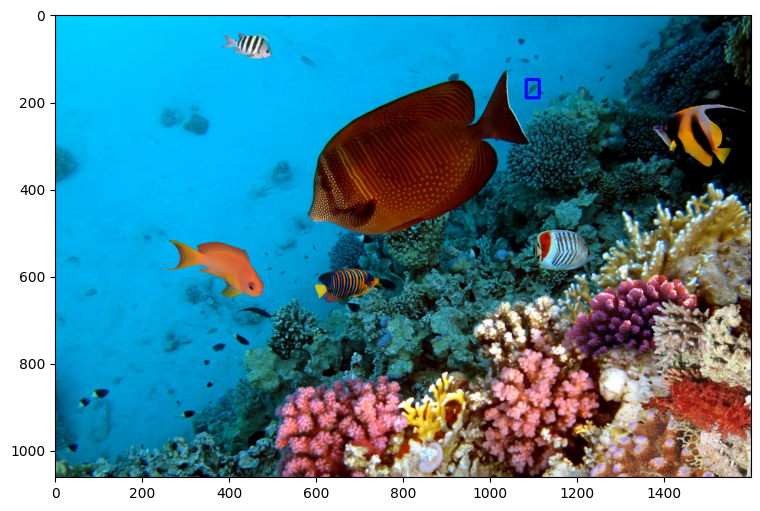

In [131]:
plt.figure(figsize=(20, 6))
plt.imshow(missing_object_on_input_image)
plt.show()

In [132]:
df_golden.sjoin_nearest(df_input, how="left", lsuffix = 'g', rsuffix= 'i', distance_col="distance")

,name_g,xmin_g,ymin_g,xmax_g,ymax_g,geometry,index_i,name_i,xmin_i,ymin_i,xmax_i,ymax_i,distance
0,big fish,251,504,485,654,"POLYGON ((251.000 504.000, 251.000 234.000, 48...",6,small fish,389,652,484,694,0.000000
0,big fish,251,504,485,654,"POLYGON ((251.000 504.000, 251.000 234.000, 48...",1,big fish,221,490,459,646,0.000000
1,small fish,583,572,748,660,"POLYGON ((583.000 572.000, 583.000 165.000, 74...",4,big fish,557,102,1045,492,0.000000
1,small fish,583,572,748,660,"POLYGON ((583.000 572.000, 583.000 165.000, 74...",8,small fish,639,640,688,676,0.000000
1,small fish,583,572,748,660,"POLYGON ((583.000 572.000, 583.000 165.000, 74...",2,small fish,579,564,723,641,0.000000
2,big fish,1080,484,1236,597,"POLYGON ((1080.000 484.000, 1080.000 156.000, ...",5,small fish,1049,132,1087,176,0.000000
3,big fish,574,122,1076,505,"POLYGON ((574.000 122.000, 574.000 502.000, 10...",4,big fish,557,102,1045,492,0.000000
3,big fish,574,122,1076,505,"POLYGON ((574.000 122.000, 574.000 502.000, 10...",7,small fish,914,514,964,556,0.000000
3,big fish,574,122,1076,505,"POLYGON ((574.000 122.000, 574.000 502.000, 10...",8,small fish,639,640,688,676,0.000000
3,big fish,574,122,1076,505,"POLYGON ((574.000 122.000, 574.000 502.000, 10...",2,small fish,579,564,723,641,0.000000
